# 第4週：喀布爾相關twitter推文進行情緒分析
**Author:** 蘇舫萱<br>
**Date created:** 2021/09/30<br>
**Last modified:** 2021/09/30<br>
本週課程為「情緒分析1」，目的為了解lexicon-base 情緒分析。情緒分析步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「英文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、資料前處理、lexicon-base 情緒分析

## 大綱
+ 1. 套件說明
+ 2. 資料前處理
    + 2.1 基本資料介紹
    + 2.2 資料清理
    + 2.3 文章斷詞
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒分數聲量折線圖圖
    + 3.4 正負向情緒分數比例折線圖圖
    + 3.5 文字雲
    + 3.6 情緒代表字
    + 3.7 情緒關鍵字

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- re: 正規表達式套件。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。

In [1]:
# 安裝會使用到的套件
# %pip install wordcloud

In [2]:
# 確認當前工作目錄
%pwd

'/home/skypc785308/SMA_2021F/week4_sentiment_analysis1'

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download("punkt") # 下載需要用到的語料庫


[nltk_data] Downloading package punkt to
[nltk_data]     /home/skypc785308/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. 資料前處理
從網路或twitter api取得的原始資料可能包含雜訊（多餘的空白、html標籤、網址等），在進行斷詞處理前應先進行資料清理。

## 2.1 基本資料介紹
- 資料來源: twitter 2021-09-14 ~ 2021-09-17 文章
- 資料集： `/raw_data/tweets.csv`
- 關鍵字：`#KabulAirport` `#Kabul`
- 資料時間：2021-09-14 ~ 2021-09-17
- 資料筆數：2936篇推文

本次主要針對以下方向分析：

- 喀布爾機場與喀布爾相關推文討論時間點與話題高峰？
- 正面和負面的討論內容各是甚麼，有沒有時間點上的差異？
- 正面和負面討論的情緒分數大約多少？

In [4]:
#匯入資料
MetaData = pd.read_csv('./raw_data/tweets.csv', encoding = 'unicode_escape')

In [5]:
print(f"共有 {MetaData.shape[0]} 篇推文")
MetaData = MetaData.iloc[:,1:7]
MetaData.head(3)

共有 2936 篇推文


,user_id,status_id,created_at,screen_name,text,source
0,1426066097690734596,1438886034125713413,2021-09-17 15:22:18,ashraf_sawaira,Inflation Rates in South Asia\r\n#Algeria #Pak...,Twitter for Android
1,1426066097690734596,1438872613124673543,2021-09-17 14:28:58,ashraf_sawaira,Pakistan GDP Per Capita ($)\r\nSource: The Wor...,Twitter for Android
2,1426066097690734596,1438174721426612226,2021-09-15 16:15:48,ashraf_sawaira,"This is man who suggested, planned and authori...",Twitter for Android


### 2.2 資料清理  
- 去除特殊字元與標點符號
- 去除html特殊字元編碼

In [6]:
def clean(row):
    text = re.sub('[\t]{2,}', '', row) #去除兩個以上空格或tab
    text = re.sub('(http|https)://.*', '', text) #去除網址(.:任意字元，*:0次以上)
    text = re.sub('&.*;', '', text) #去除html特殊字元編碼
    text = re.sub('<\w\+\w{4,}>', '', text) #去除阿拉伯字母
    text = re.sub('#_*', '', text) #去除一個或多個_
    text = re.sub('\\n', ' ', text) #去除換行
    text = re.sub('\s{2,}', ' ', text) #去除多個空格(+:一次以上)
    text = re.sub('^\\s+|\\s+$', '', text) #去除開頭/結尾有一個或多個空格
    text = re.sub('[^a-zA-Z0-9 ]', '', text) #除了字母,數字空白?!.的都去掉(表情符號去掉)
    return text

In [7]:
MetaData['text'] = MetaData.text.apply(clean)

In [8]:
MetaData.head(3)

,user_id,status_id,created_at,screen_name,text,source
0,1426066097690734596,1438886034125713413,2021-09-17 15:22:18,ashraf_sawaira,Inflation Rates in South Asia Algeria Pakistan...,Twitter for Android
1,1426066097690734596,1438872613124673543,2021-09-17 14:28:58,ashraf_sawaira,Pakistan GDP Per Capita Source The World Bank...,Twitter for Android
2,1426066097690734596,1438174721426612226,2021-09-15 16:15:48,ashraf_sawaira,This is man who suggested planned and authoriz...,Twitter for Android


### 2.3 文章斷詞
英文文集我們使用`nltk`套件進行斷詞，並進行詞幹還原與移除停用字

In [9]:
nltk.download('stopwords') # 下載nltk內建的停用字
stopWords = stopwords.words('english') # 使用英文的停用子

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/skypc785308/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
stemmer = PorterStemmer() #做Stemming還原詞幹
def getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row) # 進行斷詞
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list] # 進行詞幹還原
    seg_list = [w for w in seg_list if w not in stopWords] # 去除停用字
    return seg_list

In [11]:
MetaData['word'] = MetaData.text.apply(getToken)

In [12]:
MetaData

,user_id,status_id,created_at,screen_name,text,source,word
0,1426066097690734596,1438886034125713413,2021-09-17 15:22:18,ashraf_sawaira,Inflation Rates in South Asia Algeria Pakistan...,Twitter for Android,"[inflat, rate, south, asia, algeria, pakistan,..."
1,1426066097690734596,1438872613124673543,2021-09-17 14:28:58,ashraf_sawaira,Pakistan GDP Per Capita Source The World Bank...,Twitter for Android,"[pakistan, gdp, per, capita, sourc, world, ban..."
2,1426066097690734596,1438174721426612226,2021-09-15 16:15:48,ashraf_sawaira,This is man who suggested planned and authoriz...,Twitter for Android,"[thi, man, suggest, plan, author, fenc, durran..."
3,1225515875106684928,1438885877581811713,2021-09-17 15:21:41,BJF_111,narendramodi Pakistan will prosper after its v...,Twitter for Android,"[narendramodi, pakistan, prosper, victori, gha..."
4,1225515875106684928,1438885832463683596,2021-09-17 15:21:30,BJF_111,narendramodi BJP4India Pakistan will prosper a...,Twitter for Android,"[narendramodi, bjp4india, pakistan, prosper, v..."
...,...,...,...,...,...,...,...
2931,1435918812617007104,1437675965501554688,2021-09-14 07:13:55,Badri_313forces,Peoples love for badri313 Taliban Afghanistan ...,Twitter for iPhone,"[peopl, love, badri313, taliban, afghanistan, ..."
2932,1076898655246970881,1437674480890007552,2021-09-14 07:08:01,ngachoffat,Ashishsinhaa Taliban Afghanistan is still surr...,Twitter for Android,"[ashishsinhaa, taliban, afghanistan, still, su..."
2933,633485882,1437674294058815489,2021-09-14 07:07:17,News9Tweets,Afghanistan Taliban now incharge of the PuleC...,Twitter Web App,"[afghanistan, taliban, incharg, pulecharkhi, p..."
2934,146164092,1437673536483729410,2021-09-14 07:04:16,AbuzarBarekzai,Biometric data of NDS MOI and MOD is in the ha...,Twitter for iPhone,"[biometr, data, nd, moi, mod, hand, isi, searc..."


In [13]:
MetaData_token = MetaData.explode('word') # 將word欄位展開

In [14]:
MetaData_token.reset_index(inplace=True, drop=True) # 原本index基於文章筆數，現在需要重設index為基於斷詞數量
MetaData_token.head()

,user_id,status_id,created_at,screen_name,text,source,word
0,1426066097690734596,1438886034125713413,2021-09-17 15:22:18,ashraf_sawaira,Inflation Rates in South Asia Algeria Pakistan...,Twitter for Android,inflat
1,1426066097690734596,1438886034125713413,2021-09-17 15:22:18,ashraf_sawaira,Inflation Rates in South Asia Algeria Pakistan...,Twitter for Android,rate
2,1426066097690734596,1438886034125713413,2021-09-17 15:22:18,ashraf_sawaira,Inflation Rates in South Asia Algeria Pakistan...,Twitter for Android,south
3,1426066097690734596,1438886034125713413,2021-09-17 15:22:18,ashraf_sawaira,Inflation Rates in South Asia Algeria Pakistan...,Twitter for Android,asia
4,1426066097690734596,1438886034125713413,2021-09-17 15:22:18,ashraf_sawaira,Inflation Rates in South Asia Algeria Pakistan...,Twitter for Android,algeria


In [15]:
# 轉換日期格式
MetaData_token['created_at'] = pd.to_datetime(MetaData_token['created_at'])
MetaData_token['created_at'] = MetaData_token['created_at'].apply(lambda x: x.strftime('%Y/%m/%d'))

In [16]:
# 計算每天不同字的詞頻
word_count = MetaData_token.groupby(['created_at','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  # 排序
word_count = word_count[word_count['size']>3]  # 過濾出現太少次的字
word_count

,created_at,word,size
5109,2021/09/15,kabul,923
8825,2021/09/16,kabul,863
1522,2021/09/14,kabul,642
12047,2021/09/17,kabul,638
6609,2021/09/15,taliban,587
...,...,...,...
1926,2021/09/14,note,4
12227,2021/09/17,market,4
1416,2021/09/14,innoc,4
12099,2021/09/17,kidnapp,4


## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC情緒字典
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
- 分為正向情緒與負向情緒

In [17]:
# 讀取情緒字典
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/en/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split("\n"),file])

In [18]:
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc

,word,sentiments
0,abnormal,negative
1,abolish,negative
2,abominable,negative
3,abominably,negative
4,abominate,negative
...,...,...
6781,youthful,positive
6782,zeal,positive
6783,zenith,positive
6784,zest,positive


### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。可以先觀察每天的twitter文章數量，可以看到9/15有最多的文章數量。

In [19]:
# 轉換日期格式
MetaData['created_at'] = pd.to_datetime(MetaData['created_at'])
MetaData['created_at'] = MetaData['created_at'].apply(lambda x: x.strftime('%Y/%m/%d'))

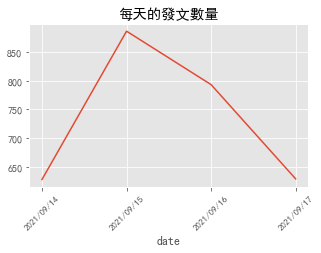

In [20]:
data_datecount = pd.DataFrame(MetaData.groupby('created_at').size(),columns = ['count'])

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('每天的發文數量')
plt.xlabel('date')
plt.xticks(rotation= 45, fontsize=9)
plt.plot(data_datecount.index,data_datecount['count'].tolist())
plt.show()

### 3.3 正負向情緒分數聲量折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [21]:
#文章和與LIWC情緒字典做合併
data = MetaData_token
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['created_at','sentiments'],as_index=False).size()
sentiment_count.head()

,created_at,sentiments,size
0,2021/09/14,negative,445
1,2021/09/14,positive,275
2,2021/09/15,negative,639
3,2021/09/15,positive,329
4,2021/09/16,negative,611


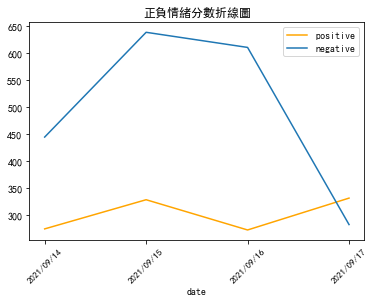

In [22]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] # 使中文能正常顯示
plt.title('正負情緒分數折線圖')
plt.plot(p['created_at'].tolist(), p['size'], label='positive', c="orange")
plt.plot(n['created_at'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend(['positive','negative']) # 顯示圖例
plt.xlabel('date')
plt.show()

畫出每天的情緒總分數，可以看到情緒大多為負向，在9/17轉為正向較多

### 3.4 正負向情緒分數比例折線圖圖

In [23]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['created_at'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

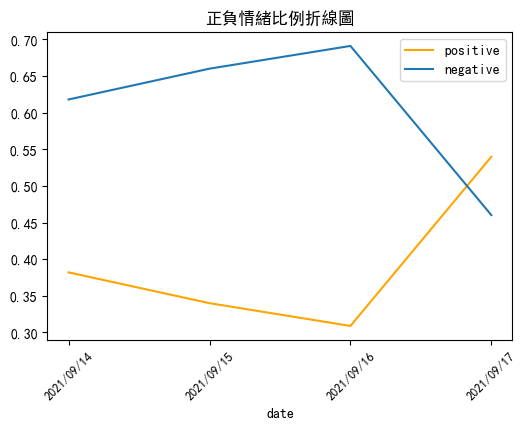

In [24]:
#sentiment_count_r = sentiment_count_r[sentiment_count_r['created_at'] > '2021/03/08']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒比例折線圖')
plt.plot(p['created_at'].tolist(), p['ratio'], label='positive', c="orange")
plt.plot(n['created_at'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend(['positive','negative']) #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('date')
plt.show()

可以看到9/14-9/16情緒以負向較多，而9/17轉為正向多出一些

### 3.4 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

### 2021-09-16 文字雲
看到2021-09-16的情緒高點看起，呼應上面負面的情緒分析，出現 Haqqani, Panjsher, rocket等詞彙。   
主要是提及塔利班相關的內容，以及當天有火箭攻擊變電站的事件所以有roket的出現。
- Haqqani : Haqqani network被視為是塔利班旗下一個重要但相對獨立的武裝組織
- Panjsher : 潘杰希爾河谷（Panjshir）反塔利班抵抗勢力

In [25]:
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('created_at == @Date') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict
    

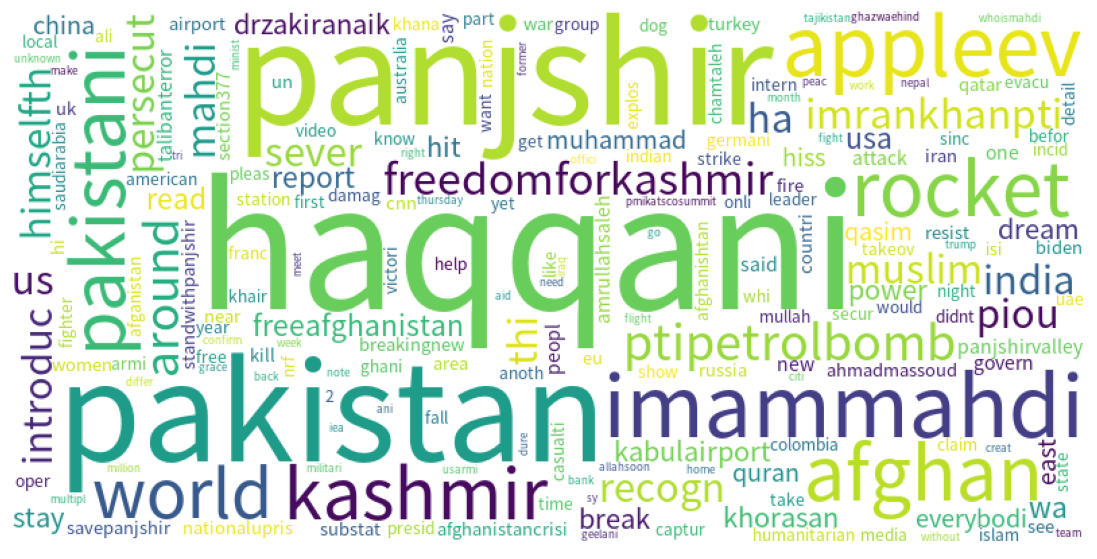

In [26]:
dict_0916 = Wc_dict(word_count, "2021/09/16", 500, 10)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_0916)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-09-17 文字雲
2021-09-17的文字雲，提到 imammahdi, piou, freedomforkashmir詞彙比例較多一些。  
推測是因為9/17有較多與 穆斯林宗教精神領袖相關的文章，當作精神寄託

- imammahdi是宗教的精神領袖，相信世界末日時將以救世主身分重返於世，主持正義。 

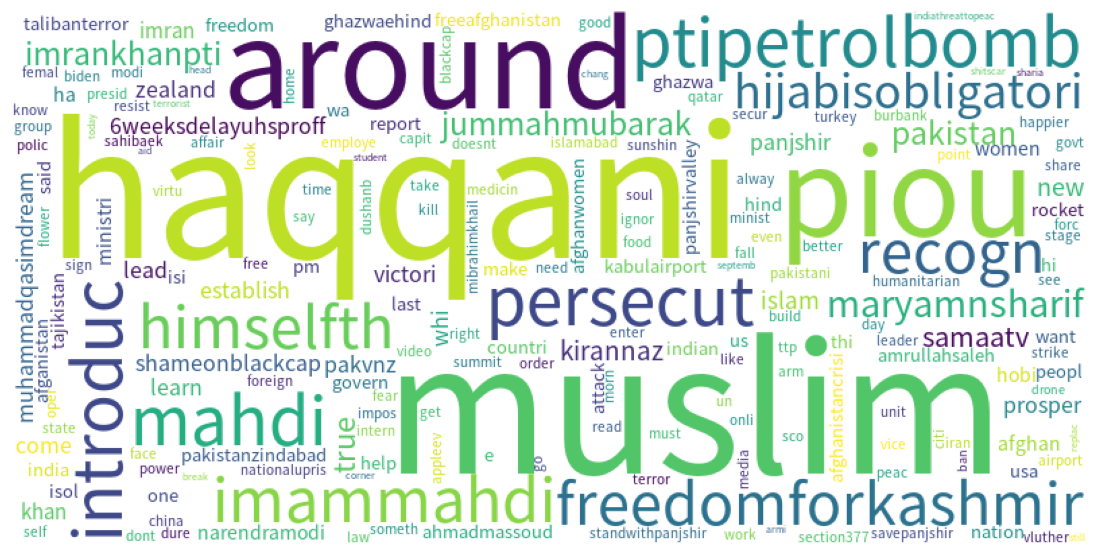

In [27]:
dict_0917 = Wc_dict(word_count,"2021/09/17",200,5)

wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_0917)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 3.5 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [28]:
sentiment_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'})
                 .sort_values(by=['size'], ascending=False)) # 排序

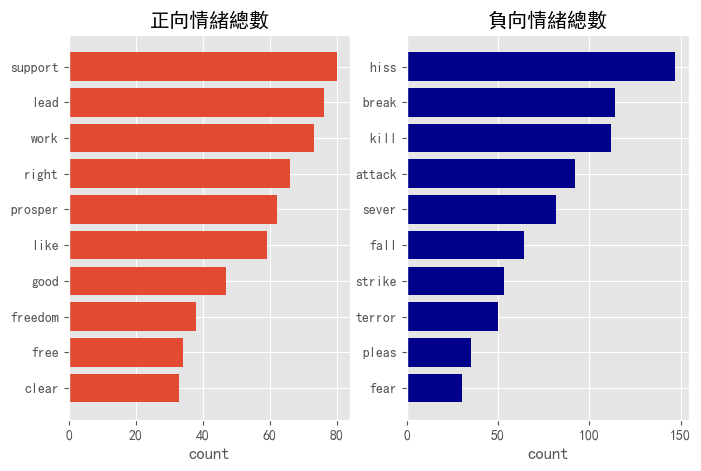

In [29]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(10).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(10).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

另外，也可以依據不同日期觀察情緒代表字的變化
### 2021-09-17 正負向情緒代表字

In [30]:
sentiment_date_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['created_at', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選日期
sentiment_0917 = sentiment_date_sum.query("created_at == '2021/09/17'").sort_values(by=['size'], ascending=False)

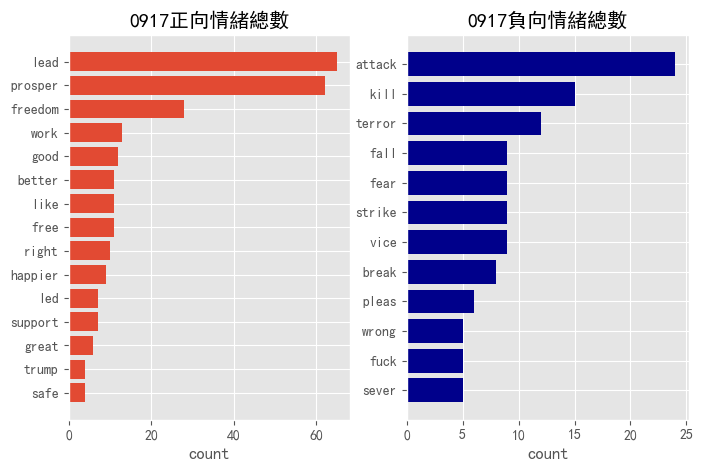

In [31]:
p_sum = sentiment_0917[sentiment_0917["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_0917[sentiment_0917["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('0917正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('0917負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

## 3.6 歸類正負面文章
- 之前的情緒分析大部分是全部的詞彙加總，接下來將正負面情緒的文章分開，看看能不能發現一些新的東西。  
- 接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。

In [32]:
data.merge(df_liwc, on='word').groupby(['text','created_at', 'sentiments'], as_index=False).size()

,text,created_at,sentiments,size
0,A group of Afghan diplomats from the deposed ...,2021/09/15,negative,1
1,America got no chill VietnamWar Saigon Afgha...,2021/09/16,negative,1
2,If Australia ScottRyan has any altercation wi...,2021/09/17,negative,2
3,If Australia ScottRyan has any altercation wi...,2021/09/17,positive,2
4,Many people are selling their goods to surviv...,2021/09/17,positive,1
...,...,...,...,...
2009,why would anyone want to hurt them such wonder...,2021/09/15,positive,1
2010,yehtuhogaaa Pakistan will prosper after its vi...,2021/09/17,positive,2
2011,yet it took just nine days for the Taliban to ...,2021/09/14,negative,1
2012,zakiaafridi Mahnoor750 fatima999 MarwaAf4 DrLi...,2021/09/17,positive,2


In [33]:
article_type = (data.merge(df_liwc, on='word')
                .groupby(['text', 'created_at', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index=['text'], columns='sentiments', values='size', fill_value=0)
                .reset_index(['text'])
               )
article_type.head()

sentiments,text,negative,positive
0,A group of Afghan diplomats from the deposed ...,1.0,0.0
1,America got no chill VietnamWar Saigon Afgha...,1.0,0.0
2,If Australia ScottRyan has any altercation wi...,2.0,2.0
3,Many people are selling their goods to surviv...,0.0,1.0
4,NEWS TruthOut Decades of Reporting on Afghan...,1.0,0.0


In [34]:
# 如果該文章的正面情緒大於負面情緒，則歸類該文章為正面(positive)，反之則歸類為負面(negative)
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,1123
1,positive,517


### 正負情緒文章數量統計圖

In [35]:
article_type_date = article_type.merge(MetaData.loc[:,["text", "created_at"]], how = 'left', on = 'text')
article_type_date = article_type_date.groupby(['created_at','type'], as_index=False).size()
article_type_date

,created_at,type,size
0,2021/09/14,negative,261
1,2021/09/14,positive,142
2,2021/09/15,negative,419
3,2021/09/15,positive,141
4,2021/09/16,negative,375
5,2021/09/16,positive,128
6,2021/09/17,negative,157
7,2021/09/17,positive,150


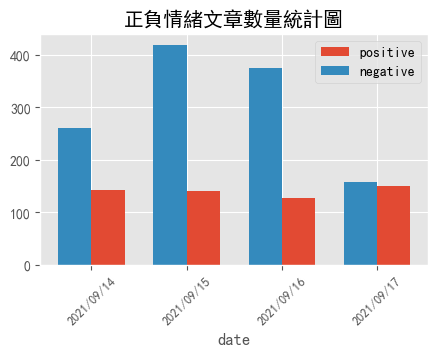

In [36]:
ap = article_type_date[article_type_date["type"]=="positive"]
an = article_type_date[article_type_date["type"]=="negative"]

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('date')
plt.bar(ap['created_at'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['created_at'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('date')
plt.show()

### 3.7 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併

In [37]:
positive_article = article_type[article_type["type"]=="positive"].merge(data, how = 'left', on = 'text')
negative_article = article_type[article_type["type"]=="negative"].merge(data, how = 'left', on = 'text')

### 情緒關鍵字:負面情緒文章

In [38]:
negative_article = (negative_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

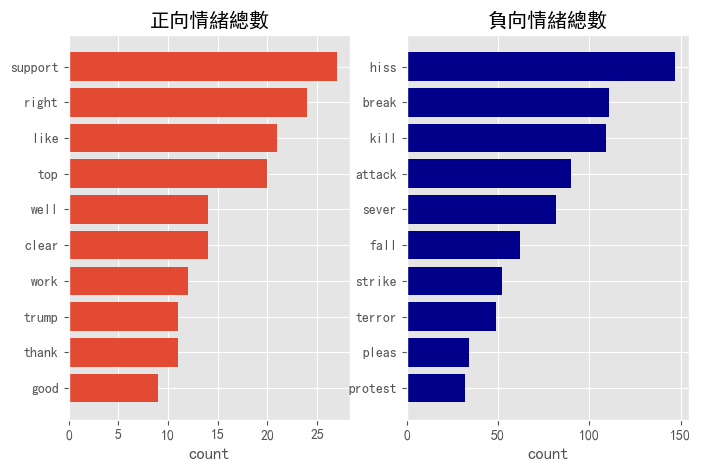

In [39]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(10).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(10).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 情緒關鍵字:正面情緒文章

In [40]:
positive_article = (positive_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

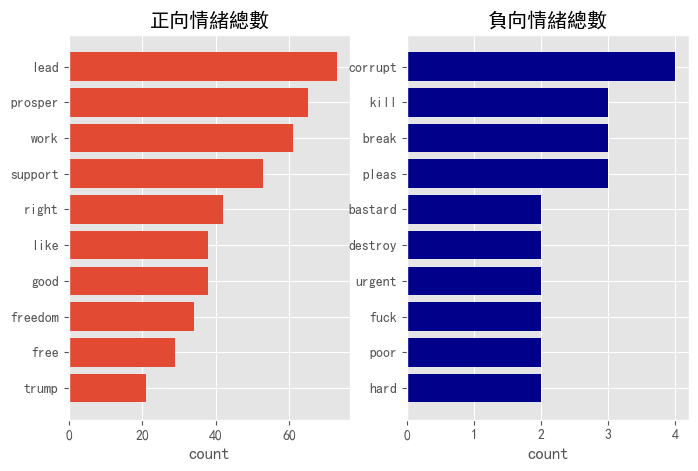

In [41]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(10).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(10).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

從正負面情緒圖觀察發現，正面和負面的關鍵字差異不大。  
負面情緒較高的文章比較常出現 attack, strike, terror, protest等字詞，比較著重在討論塔利班接手後的攻擊事件及一些施政行為與女性受到壓迫的問題   
正面情緒較高的文章出現較多的 prosper, support, right, freedom等字詞，主要是在感謝各界的支援與協助，以及對宗教精神領袖的寄託。